<a href="https://colab.research.google.com/github/fernanda0402/Doutorado/blob/main/An%C3%A1lise_e_teste_GP_erro_0_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Bibliotecas:

import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp
import scipy.interpolate as interp
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.optimize import curve_fit

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install pyccl

In [ ]:
import pyccl as ccl

In [ ]:
!pip install git+https://github.com/JCGoran/GaPP@feature/python3#GaPP
from gapp import gp
from numpy import loadtxt, savetxt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

Primeiramente vamos considerar dz = 0.05 e erro igual a 1%.

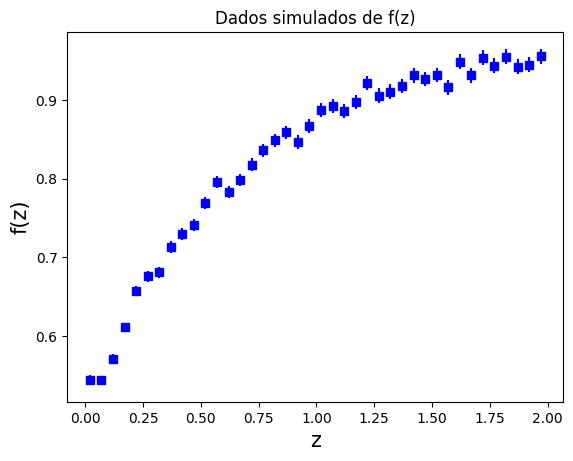

In [ ]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, h=0.6727, sigma8=0.8120, n_s=0.9649,
    matter_power_spectrum='linear')


z = np.arange(0.02, 2, 0.05)

a = 1. / (1. + z)

# fz mocks

fz = ccl.growth_rate(cosmo, a)

efz = 0.01 * fz


fz = np.random.normal(fz, 0.01)

# plote

plt.xlabel('z', fontsize=15)
plt.ylabel('f(z)', fontsize=15)
plt.title('Dados simulados de f(z)')
plt.errorbar(z, fz, efz, fmt='s', color='blue')
plt.show()


# salvando os dados

Nfz = z, fz, efz
#np.savetxt('fz_mocks.dat', np.transpose(Nfz), delimiter='\t')


Optimized hyperparameters:
theta = [0.71607298 1.53322721]


<ipython-input-8-4dd417bbb368>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')


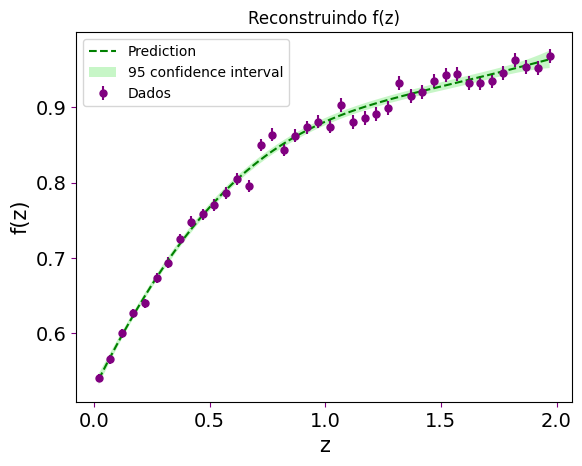

In [ ]:
# baixando os dados
data = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/fz_mocks.dat', delimiter='\t')

z_gapp = data[:, 0]

f_gapp = data[:, 1]

sig_f = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = f_gapp
e = sig_f

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_gapp)
xmax = max(x_gapp)
nstar = 200

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'95 confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('f(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstruindo f(z)')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('fz_recon_mock.dat', np.transpose(H), delimiter='\t')


Optimized hyperparameters:
theta = [0.71607298 1.53322721]


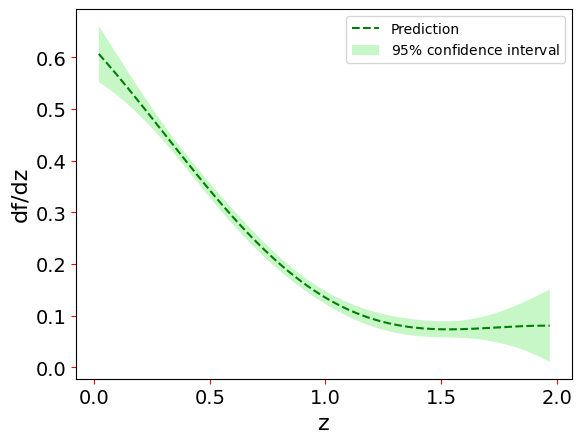

In [ ]:
# primeira derivada

from gapp import dgp

# baixando os dados
data = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/fz_mocks.dat', delimiter='\t')

z_gapp = data[:, 0]

f_gapp = data[:, 1]

sig_f = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = f_gapp
e = sig_f

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_gapp)
xmax = max(x_gapp)
nstar = 200

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(theta=initheta)

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14,color='red')
plt.plot(xi, y_pred, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('df/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('dfz_recon_mock.dat', np.transpose(H), delimiter='\t')

Razão $\frac{1}{f(z)} \frac{df}{dz}$.

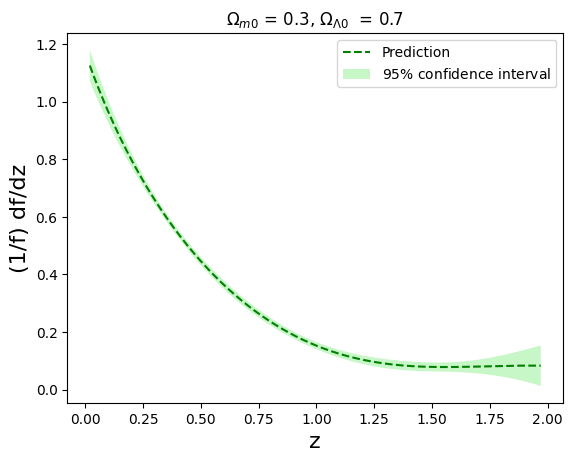

In [ ]:
# baixando e nomeando dados
fzrec = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/fz_recon_mock.dat', delimiter='\t')

z_dgapp = fzrec[:, 0]
f_dgapp = fzrec[:, 1]

ef = fzrec[:, 2]

dfzrec = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/dfz_recon_mock.dat', delimiter='\t')

df = dfzrec[:, 1]

edf = dfzrec[:, 2]

df_f = df / f_dgapp

sigma_ff = np.sqrt(((df_f) ** 2) * (((ef / f_dgapp) ** 2) + ((edf / df) ** 2)))


# PLOTE
plt.plot(z_dgapp, df_f, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([z_dgapp, z_dgapp[::-1]]),
         np.concatenate([df_f - 1.9600 * sigma,
                        (df_f + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.title('$\Omega_{m0}$ = 0.3, $\Omega_{\Lambda 0}$  = 0.7 ')
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/f) df/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

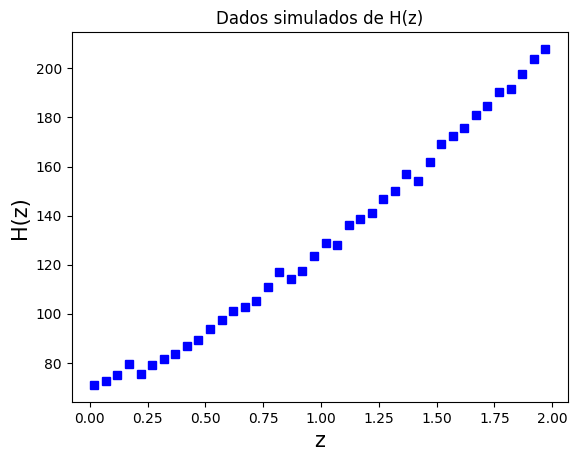

In [ ]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, h=0.6727, sigma8=0.8120, n_s=0.9649,
    matter_power_spectrum='linear')


z = np.arange(0.02, 2, 0.05)

a = 1. / (1. + z)

# hz mocks
H0 = 70

Hz = H0 * ccl.background.h_over_h0(cosmo, a)

ehz = 0.01 * Hz


Hz = np.random.normal(Hz, 2)

# plote

plt.xlabel('z', fontsize=15)
plt.ylabel('H(z)', fontsize=15)
plt.title('Dados simulados de H(z)')
plt.errorbar(z, Hz, efz, fmt='s', color='blue')
plt.show()


# salvando os dados

NHz = z, Hz, ehz
#np.savetxt('Hz_mocks.dat', np.transpose(NHz), delimiter='\t')


Optimized hyperparameters:
theta = [258.25288414   3.50078594]


<ipython-input-13-7a82706b9486>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_h, y_h, e, fmt='r.', color='purple', markersize=10, label='Dados')


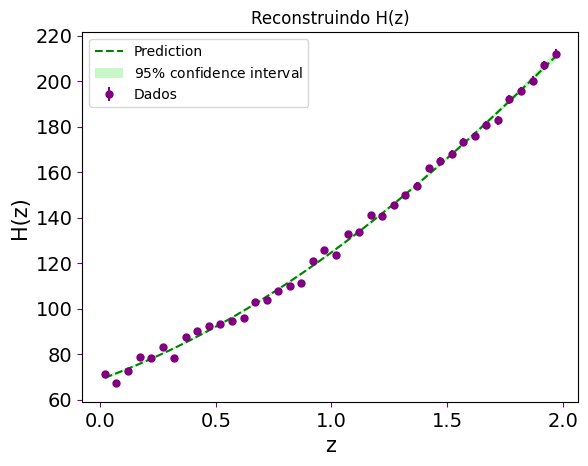

In [ ]:
# baixando os dados
data_h = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/Hz_mocks.dat', delimiter='\t')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# nomeando
x_h = z_h
y_h = h
e = sig_h

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_h)
xmax = max(x_h)
nstar = 200

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_h, y_h, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.errorbar(x_h, y_h, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('H(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstruindo H(z)')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('hz_recon_mock.dat', np.transpose(H), delimiter='\t')


Optimized hyperparameters:
theta = [258.25288414   3.50078594]


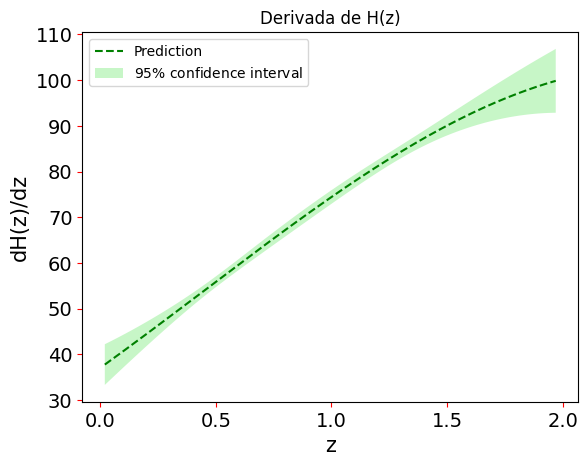

In [ ]:
# primeira derivada

from gapp import dgp

# baixando os dados
data_h = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/Hz_mocks.dat', delimiter='\t')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# nomeando
x_h = z_h
y_h = h
e = sig_h

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_h)
xmax = max(x_h)
nstar = 200

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_h, y_h, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(theta=initheta)

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14,color='red')
plt.plot(xi, y_pred, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('dH(z)/dz', fontsize=15)
plt.legend(loc='best')
plt.title('Derivada de H(z)')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('dhz_recon_mock.dat', np.transpose(H), delimiter='\t')

Razão $\frac{1}{H(z)} \frac{dH}{dz}$.

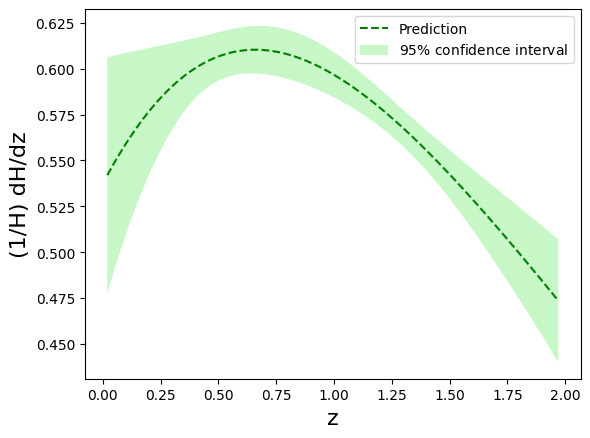

In [ ]:
# baixando e nomeando dados reconstruídos de H
hz = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/hz_recon_mock.dat', delimiter='\t')

z_hz = hz[:, 0]
h_hz = hz[:, 1]

ehz = hz[:, 2]

# baixando e nomeando dados reconstruídos da derivada de H
dhz = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/dhz_recon_mock.dat', delimiter='\t')

z_dhz = dhz[:, 0]

dh = dhz[:, 1]

edh = dhz[:, 2]

dh_h = dh / h_hz  # H'/H

sigma_H = np.sqrt(((dh_h) ** 2) * (((ehz / h_hz) ** 2) + ((edh / dh) ** 2)))


# PLOTE
plt.plot(z_dhz, dh_h, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([dh_h - 1.9600 * sigma_H,
                        (dh_h + 1.9600 * sigma_H)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/H) dH/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

Usaremos o que obtivemos de $H'/H$ para plotar $\frac{\Omega_m '}{\Omega_m}$.

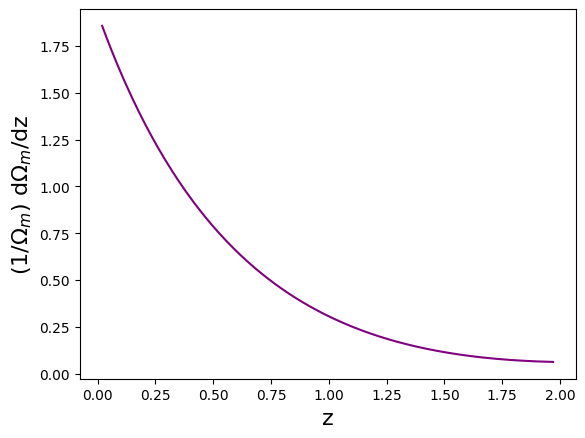

In [ ]:
# definindo Om'/Om

dOm_Om = (3/(1+z_dhz)) - (2*dh_h)   #dh_h vem da reconstrução dos dados

eOm = np.sqrt( (2*sigma_H)**2 )

plt.plot(z_dhz, dOm_Om, color='purple')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/$\Omega_m$) d$\Omega_m$/dz', fontsize=16)
plt.show()

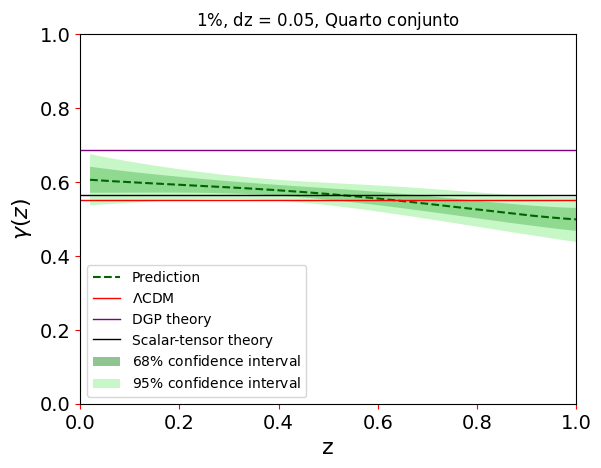

In [ ]:
# gamma prediction

gamma_pred = df_f / dOm_Om

sigma_g = np.sqrt( (sigma_ff / dOm_Om )**2 + ( ( (df_f*eOm)/ ((dOm_Om)**2) ) )**2)


# gamma lcdm
gamma_lcdm = 0.55

# gamma dgp
gamma_dgp = 0.6875

# gamma scalar tensor
gamma_st = 0.564

# PLOTE

fig, ax = plt.subplots()
plt.ylim(0,1)
plt.xlim(0,1.0)
plt.tick_params(labelsize=14, color='red')
plt.plot(z_dhz, gamma_pred, color='darkgreen', label='Prediction', linestyle="--")
plt.axhline(y=0.55, color='red', linestyle='-', linewidth=1, label='$\Lambda$CDM')
plt.axhline(y=0.6875, color='purple', linestyle='-', linewidth=1, label='DGP theory')
plt.axhline(y=0.564, color='black', linestyle='-', linewidth=1, label='Scalar-tensor theory')
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([gamma_pred - 1.0000 * sigma_g,
                        (gamma_pred + 1.0000 * sigma_g)[::-1]]),
         alpha=.5, fc='forestgreen', ec='None', label='$68\%$ confidence interval')
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([gamma_pred - 1.9600 * sigma_g,
                        (gamma_pred + 1.9600 * sigma_g)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('$\gamma(z)$', fontsize=16)
plt.legend(loc='best')
#plt.savefig('gamma_cte.pdf')
plt.title('$1\%$, dz = 0.05, Quarto conjunto')
plt.show()

Agora, vamos considerar dz = 0.1 e o erro se mantendo em 1%.

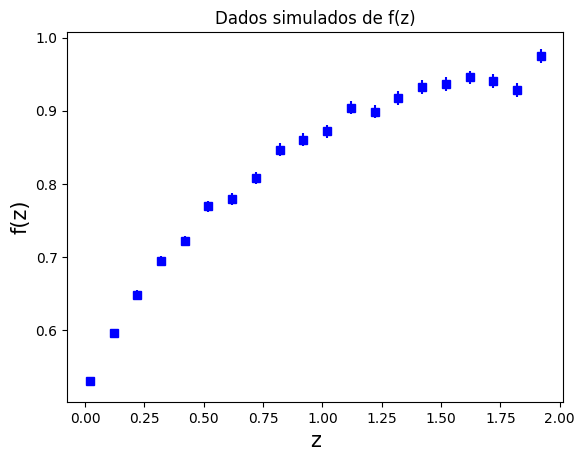

In [ ]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, h=0.6727, sigma8=0.8120, n_s=0.9649,
    matter_power_spectrum='linear')


z = np.arange(0.02, 2, 0.1)

a = 1. / (1. + z)

# fz mocks

fz = ccl.growth_rate(cosmo, a)

efz = 0.01 * fz


fz = np.random.normal(fz, 0.01)

# plote

plt.xlabel('z', fontsize=15)
plt.ylabel('f(z)', fontsize=15)
plt.title('Dados simulados de f(z)')
plt.errorbar(z, fz, efz, fmt='s', color='blue')
plt.show()


# salvando os dados

Nfz = z, fz, efz
#np.savetxt('fz_mocks_01.dat', np.transpose(Nfz), delimiter='\t')


Optimized hyperparameters:
theta = [0.87779274 1.88924948]


<ipython-input-19-542ddb9a8b66>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')


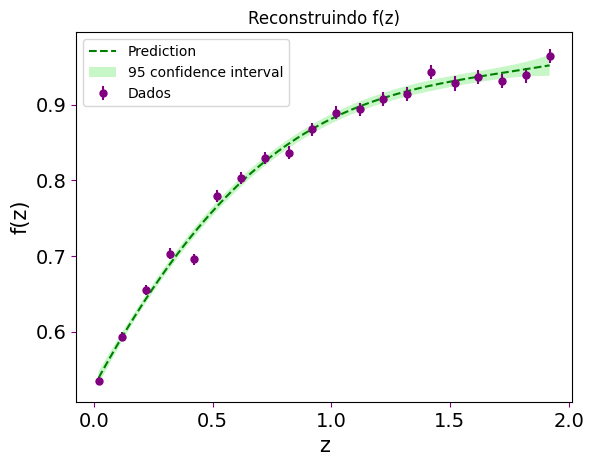

In [ ]:
# baixando os dados
data = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/fz_mocks_01.dat', delimiter='\t')

z_gapp = data[:, 0]

f_gapp = data[:, 1]

sig_f = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = f_gapp
e = sig_f

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_gapp)
xmax = max(x_gapp)
nstar = 200

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'95 confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('f(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstruindo f(z)')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('fz_recon_mock_01.dat', np.transpose(H), delimiter='\t')


Optimized hyperparameters:
theta = [0.87779274 1.88924948]


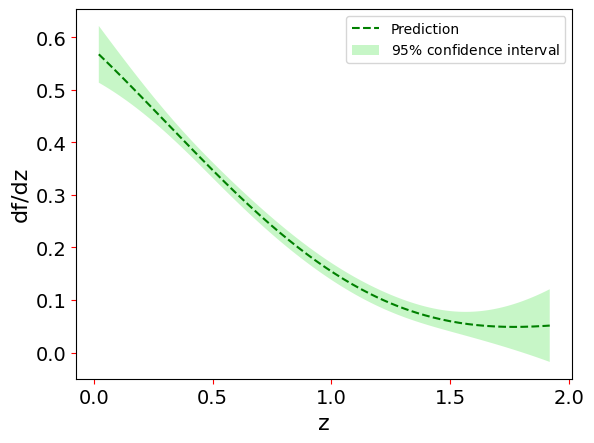

In [ ]:
# primeira derivada

from gapp import dgp

# baixando os dados
data = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/fz_mocks_01.dat', delimiter='\t')

z_gapp = data[:, 0]

f_gapp = data[:, 1]

sig_f = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = f_gapp
e = sig_f

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_gapp)
xmax = max(x_gapp)
nstar = 200

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(theta=initheta)

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14,color='red')
plt.plot(xi, y_pred, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('df/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('dfz_recon_mock_01.dat', np.transpose(H), delimiter='\t')

Razão $\frac{1}{f(z)} \frac{df}{dz}$.

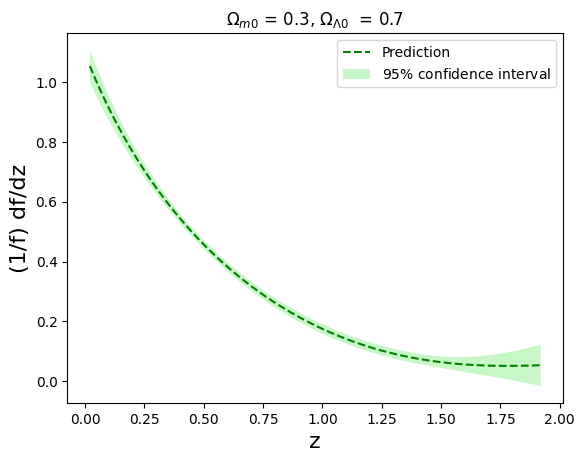

In [ ]:
# baixando e nomeando dados
fzrec = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/fz_recon_mock_01.dat', delimiter='\t')

z_dgapp = fzrec[:, 0]
f_dgapp = fzrec[:, 1]

ef = fzrec[:, 2]

dfzrec = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/dfz_recon_mock_01.dat', delimiter='\t')

df = dfzrec[:, 1]

edf = dfzrec[:, 2]

df_f = df / f_dgapp

sigma_ff = np.sqrt(((df_f) ** 2) * (((ef / f_dgapp) ** 2) + ((edf / df) ** 2)))


# PLOTE
plt.plot(z_dgapp, df_f, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([z_dgapp, z_dgapp[::-1]]),
         np.concatenate([df_f - 1.9600 * sigma,
                        (df_f + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.title('$\Omega_{m0}$ = 0.3, $\Omega_{\Lambda 0}$  = 0.7 ')
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/f) df/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

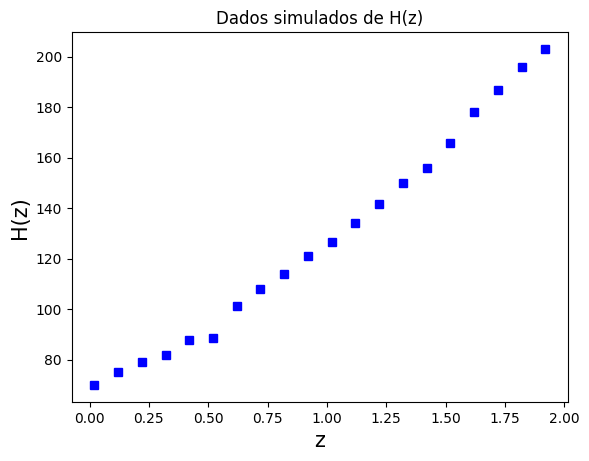

In [ ]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, h=0.6727, sigma8=0.8120, n_s=0.9649,
    matter_power_spectrum='linear')


z = np.arange(0.02, 2, 0.1)

a = 1. / (1. + z)

# hz mocks
H0 = 70

Hz = H0 * ccl.background.h_over_h0(cosmo, a)

ehz = 0.01 * Hz


Hz = np.random.normal(Hz, 2)

# plote

plt.xlabel('z', fontsize=15)
plt.ylabel('H(z)', fontsize=15)
plt.title('Dados simulados de H(z)')
plt.errorbar(z, Hz, efz, fmt='s', color='blue')
plt.show()


# salvando os dados

NHz = z, Hz, ehz
#np.savetxt('Hz_mocks_01.dat', np.transpose(NHz), delimiter='\t')


Optimized hyperparameters:
theta = [219.52983983   3.15066477]


<ipython-input-24-c1662915dad0>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_h, y_h, e, fmt='r.', color='purple', markersize=10, label='Dados')


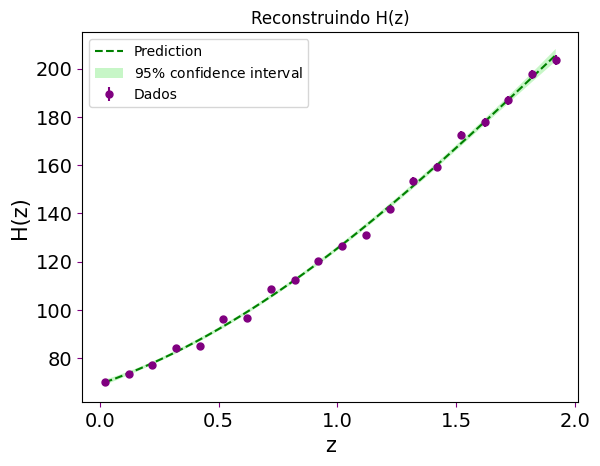

In [ ]:
# baixando os dados
data_h = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/Hz_mocks_01.dat', delimiter='\t')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# nomeando
x_h = z_h
y_h = h
e = sig_h

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_h)
xmax = max(x_h)
nstar = 200

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_h, y_h, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.errorbar(x_h, y_h, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('H(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstruindo H(z)')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('hz_recon_mock_01.dat', np.transpose(H), delimiter='\t')


Optimized hyperparameters:
theta = [219.52983983   3.15066477]


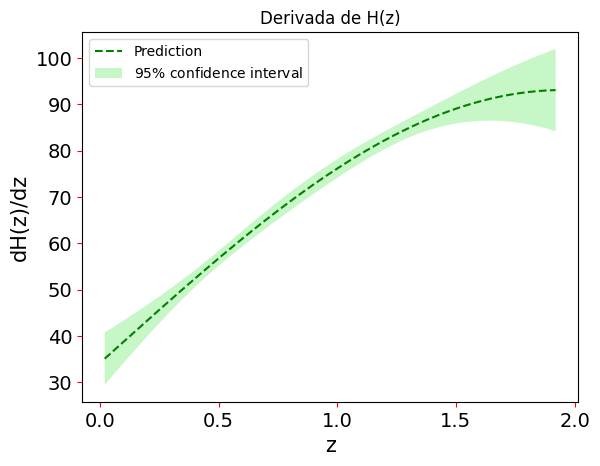

In [ ]:
# primeira derivada

from gapp import dgp

# baixando os dados
data_h = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/Hz_mocks_01.dat', delimiter='\t')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# nomeando
x_h = z_h
y_h = h
e = sig_h

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_h)
xmax = max(x_h)
nstar = 200

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_h, y_h, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(theta=initheta)

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14,color='red')
plt.plot(xi, y_pred, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('dH(z)/dz', fontsize=15)
plt.legend(loc='best')
plt.title('Derivada de H(z)')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('dhz_recon_mock_01.dat', np.transpose(H), delimiter='\t')

Razão $\frac{1}{H(z)} \frac{dH}{dz}$.

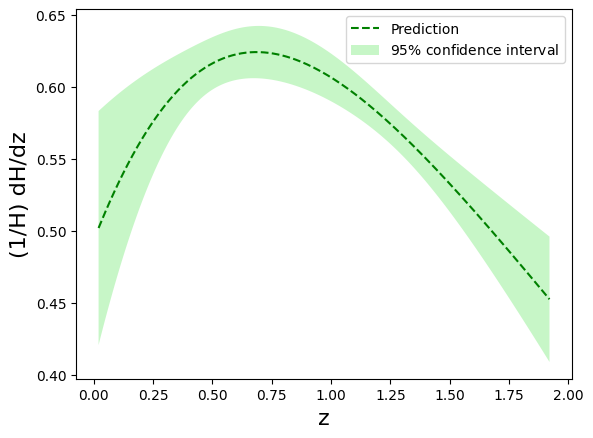

In [ ]:
# baixando e nomeando dados reconstruídos de H
hz = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/hz_recon_mock_01.dat', delimiter='\t')

z_hz = hz[:, 0]
h_hz = hz[:, 1]

ehz = hz[:, 2]

# baixando e nomeando dados reconstruídos da derivada de H
dhz = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/dhz_recon_mock_01.dat', delimiter='\t')

z_dhz = dhz[:, 0]

dh = dhz[:, 1]

edh = dhz[:, 2]

dh_h = dh / h_hz  # H'/H

sigma_H = np.sqrt(((dh_h) ** 2) * (((ehz / h_hz) ** 2) + ((edh / dh) ** 2)))


# PLOTE
plt.plot(z_dhz, dh_h, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([dh_h - 1.9600 * sigma_H,
                        (dh_h + 1.9600 * sigma_H)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/H) dH/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

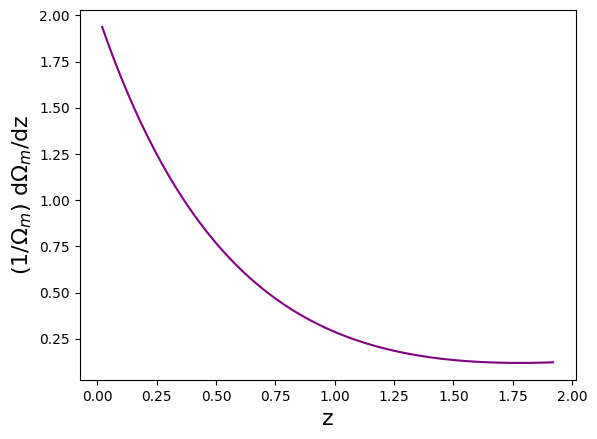

In [ ]:
# definindo Om'/Om

dOm_Om = (3/(1+z_dhz)) - (2*dh_h)   #dh_h vem da reconstrução dos dados

eOm = np.sqrt( (2*sigma_H)**2 )

plt.plot(z_dhz, dOm_Om, color='purple')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/$\Omega_m$) d$\Omega_m$/dz', fontsize=16)
plt.show()

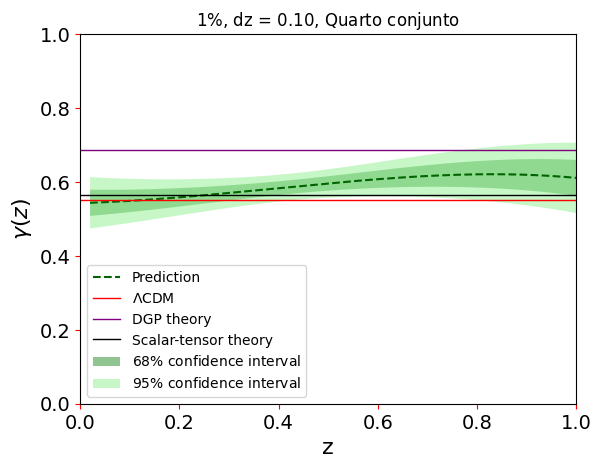

In [ ]:
# gamma prediction

gamma_pred = df_f / dOm_Om

sigma_g = np.sqrt( (sigma_ff / dOm_Om )**2 + ( ( (df_f*eOm)/ ((dOm_Om)**2) ) )**2)


# gamma lcdm
gamma_lcdm = 0.55

# gamma dgp
gamma_dgp = 0.6875

# gamma scalar tensor
gamma_st = 0.564

# PLOTE

fig, ax = plt.subplots()
plt.ylim(0,1)
plt.xlim(0,1.0)
plt.tick_params(labelsize=14, color='red')
plt.plot(z_dhz, gamma_pred, color='darkgreen', label='Prediction', linestyle="--")
plt.axhline(y=0.55, color='red', linestyle='-', linewidth=1, label='$\Lambda$CDM')
plt.axhline(y=0.6875, color='purple', linestyle='-', linewidth=1, label='DGP theory')
plt.axhline(y=0.564, color='black', linestyle='-', linewidth=1, label='Scalar-tensor theory')
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([gamma_pred - 1.0000 * sigma_g,
                        (gamma_pred + 1.0000 * sigma_g)[::-1]]),
         alpha=.5, fc='forestgreen', ec='None', label='$68\%$ confidence interval')
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([gamma_pred - 1.9600 * sigma_g,
                        (gamma_pred + 1.9600 * sigma_g)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('$\gamma(z)$', fontsize=16)
plt.legend(loc='best')
#plt.savefig('gamma_cte.pdf')
plt.title('$1\%$, dz = 0.10, Quarto conjunto')
plt.show()

Agora, vamos considerar dz = 0.15 e o erro se mantendo em 1%.

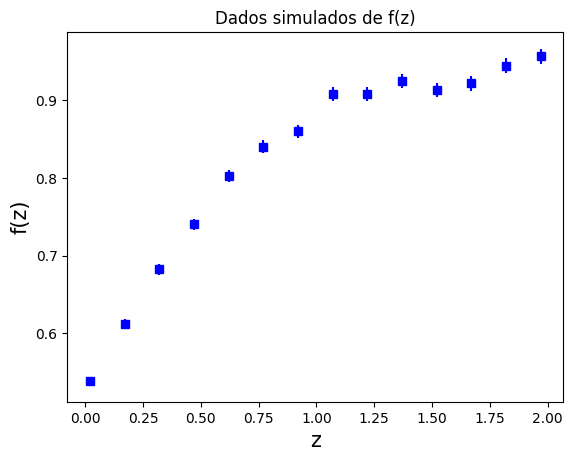

In [ ]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, h=0.6727, sigma8=0.8120, n_s=0.9649,
    matter_power_spectrum='linear')


z = np.arange(0.02, 2, 0.15)

a = 1. / (1. + z)

# fz mocks

fz = ccl.growth_rate(cosmo, a)

efz = 0.01 * fz


fz = np.random.normal(fz, 0.01)

# plote

plt.xlabel('z', fontsize=15)
plt.ylabel('f(z)', fontsize=15)
plt.title('Dados simulados de f(z)')
plt.errorbar(z, fz, efz, fmt='s', color='blue')
plt.show()


# salvando os dados

Nfz = z, fz, efz
#np.savetxt('fz_mocks_015.dat', np.transpose(Nfz), delimiter='\t')


Optimized hyperparameters:
theta = [0.77368739 1.4124891 ]


<ipython-input-31-0e809202c381>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')


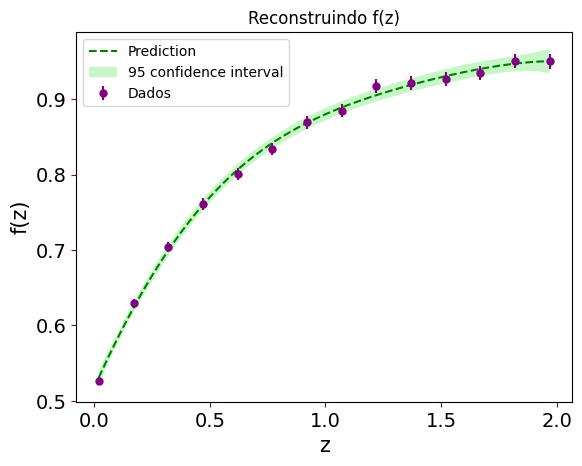

In [ ]:
# baixando os dados
data = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/fz_mocks_015.dat', delimiter='\t')

z_gapp = data[:, 0]

f_gapp = data[:, 1]

sig_f = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = f_gapp
e = sig_f

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_gapp)
xmax = max(x_gapp)
nstar = 200

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'95 confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('f(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstruindo f(z)')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('fz_recon_mock_015.dat', np.transpose(H), delimiter='\t')


Optimized hyperparameters:
theta = [0.77368739 1.4124891 ]


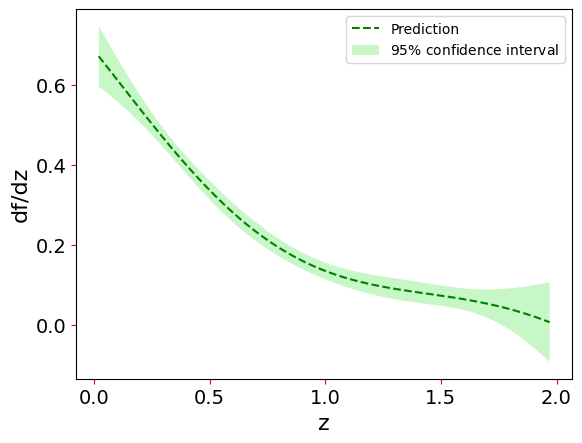

In [ ]:
# primeira derivada

from gapp import dgp

# baixando os dados
data = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/fz_mocks_015.dat', delimiter='\t')

z_gapp = data[:, 0]

f_gapp = data[:, 1]

sig_f = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = f_gapp
e = sig_f

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_gapp)
xmax = max(x_gapp)
nstar = 200

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(theta=initheta)

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14,color='red')
plt.plot(xi, y_pred, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('df/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('dfz_recon_mock_015.dat', np.transpose(H), delimiter='\t')

Razão $\frac{1}{f(z)} \frac{df}{dz}$.

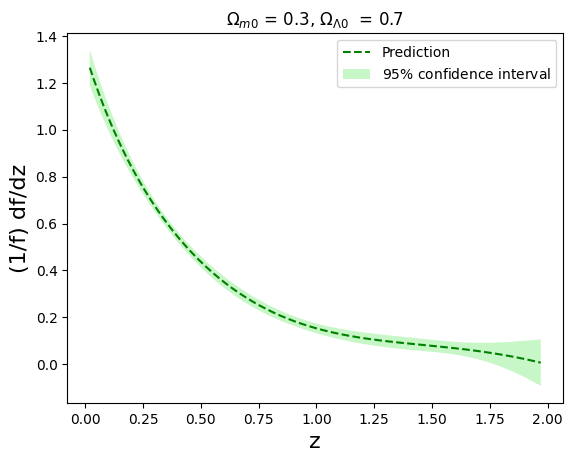

In [ ]:
# baixando e nomeando dados
fzrec = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/fz_recon_mock_015.dat', delimiter='\t')

z_dgapp = fzrec[:, 0]
f_dgapp = fzrec[:, 1]

ef = fzrec[:, 2]

dfzrec = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/dfz_recon_mock_015.dat', delimiter='\t')

df = dfzrec[:, 1]

edf = dfzrec[:, 2]

df_f = df / f_dgapp

sigma_ff = np.sqrt(((df_f) ** 2) * (((ef / f_dgapp) ** 2) + ((edf / df) ** 2)))


# PLOTE
plt.plot(z_dgapp, df_f, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([z_dgapp, z_dgapp[::-1]]),
         np.concatenate([df_f - 1.9600 * sigma,
                        (df_f + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.title('$\Omega_{m0}$ = 0.3, $\Omega_{\Lambda 0}$  = 0.7 ')
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/f) df/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

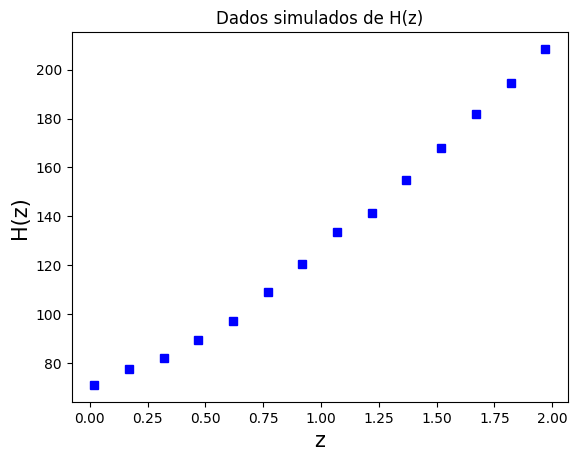

In [ ]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, h=0.6727, sigma8=0.8120, n_s=0.9649,
    matter_power_spectrum='linear')


z = np.arange(0.02, 2, 0.15)

a = 1. / (1. + z)

# hz mocks
H0 = 70

Hz = H0 * ccl.background.h_over_h0(cosmo, a)

ehz = 0.01 * Hz


Hz = np.random.normal(Hz, 2)

# plote

plt.xlabel('z', fontsize=15)
plt.ylabel('H(z)', fontsize=15)
plt.title('Dados simulados de H(z)')
plt.errorbar(z, Hz, efz, fmt='s', color='blue')
plt.show()


# salvando os dados

NHz = z, Hz, ehz
#np.savetxt('Hz_mocks_015.dat', np.transpose(NHz), delimiter='\t')


Optimized hyperparameters:
theta = [350.2346953    4.19635414]


<ipython-input-35-27415a0abec0>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_h, y_h, e, fmt='r.', color='purple', markersize=10, label='Dados')


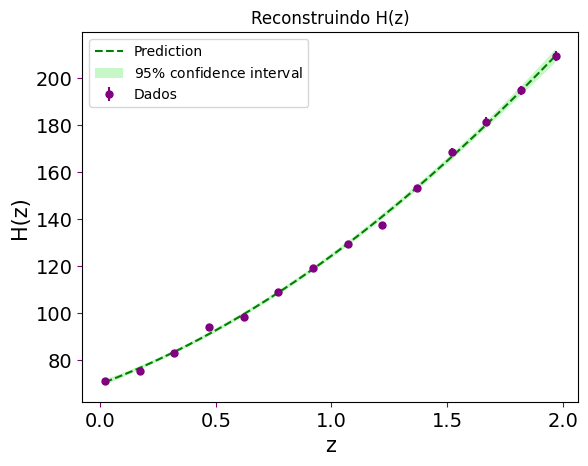

In [ ]:
# baixando os dados
data_h = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/Hz_mocks_015.dat', delimiter='\t')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# nomeando
x_h = z_h
y_h = h
e = sig_h

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_h)
xmax = max(x_h)
nstar = 200

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_h, y_h, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.errorbar(x_h, y_h, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('H(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstruindo H(z)')
plt.show()

H = xi, y_pred, sigma

np.savetxt('hz_recon_mock_015.dat', np.transpose(H), delimiter='\t')


Optimized hyperparameters:
theta = [350.2346953    4.19635414]


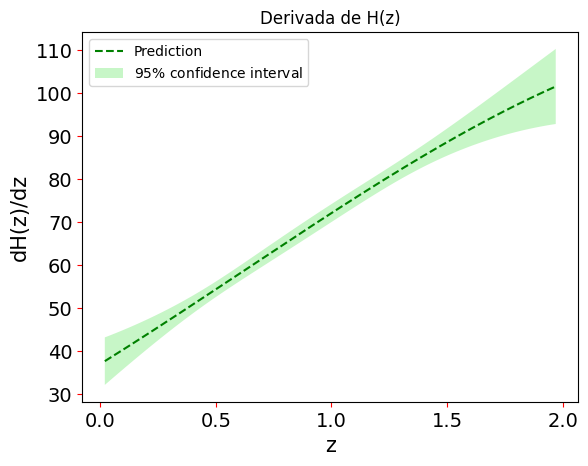

In [ ]:
# primeira derivada

from gapp import dgp

# baixando os dados
data_h = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/Hz_mocks_015.dat', delimiter='\t')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# nomeando
x_h = z_h
y_h = h
e = sig_h

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_h)
xmax = max(x_h)
nstar = 200

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_h, y_h, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(theta=initheta)

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14,color='red')
plt.plot(xi, y_pred, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('dH(z)/dz', fontsize=15)
plt.legend(loc='best')
plt.title('Derivada de H(z)')
plt.show()

H = xi, y_pred, sigma

np.savetxt('dhz_recon_mock_015.dat', np.transpose(H), delimiter='\t')

Razão $\frac{1}{H(z)} \frac{dH}{dz}$.

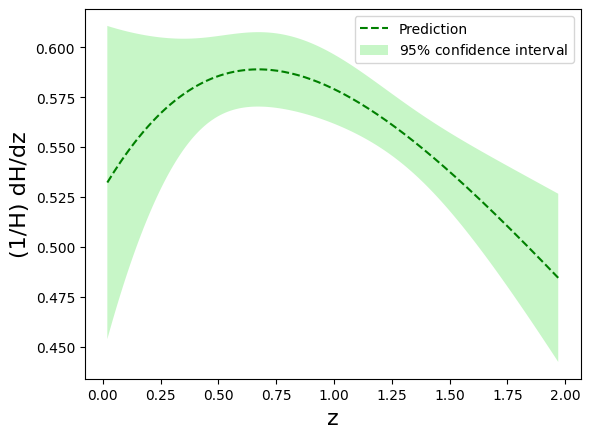

In [ ]:
# baixando e nomeando dados reconstruídos de H
hz = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/hz_recon_mock_015.dat', delimiter='\t')

z_hz = hz[:, 0]
h_hz = hz[:, 1]

ehz = hz[:, 2]

# baixando e nomeando dados reconstruídos da derivada de H
dhz = np.genfromtxt('/content/drive/MyDrive/Doutorado/Dados/Mocks/dhz_recon_mock_015.dat', delimiter='\t')

z_dhz = dhz[:, 0]

dh = dhz[:, 1]

edh = dhz[:, 2]

dh_h = dh / h_hz  # H'/H

sigma_H = np.sqrt(((dh_h) ** 2) * (((ehz / h_hz) ** 2) + ((edh / dh) ** 2)))


# PLOTE
plt.plot(z_dhz, dh_h, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([dh_h - 1.9600 * sigma_H,
                        (dh_h + 1.9600 * sigma_H)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/H) dH/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

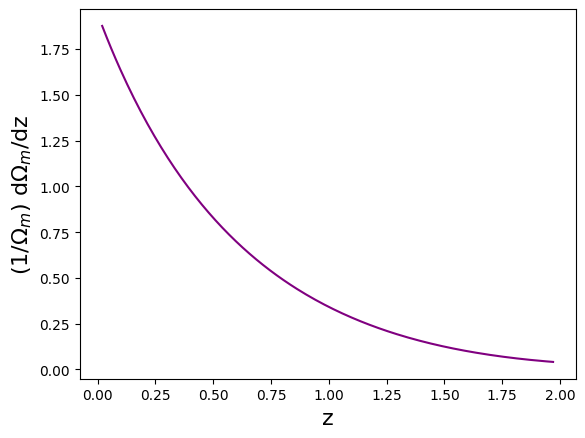

In [ ]:
# definindo Om'/Om

dOm_Om = (3/(1+z_dhz)) - (2*dh_h)   #dh_h vem da reconstrução dos dados

eOm = np.sqrt( (2*sigma_H)**2 )

plt.plot(z_dhz, dOm_Om, color='purple')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/$\Omega_m$) d$\Omega_m$/dz', fontsize=16)
plt.show()

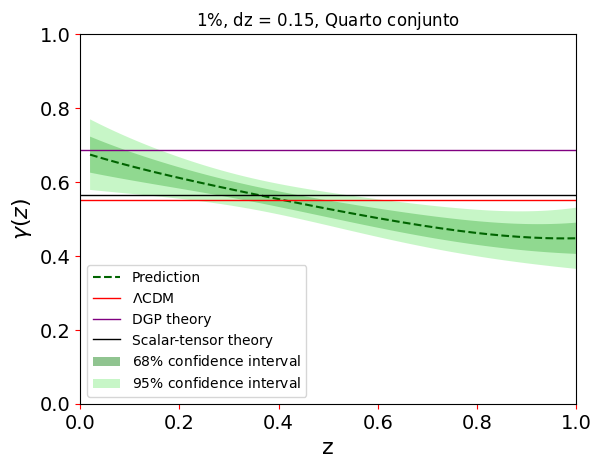

In [ ]:
# gamma prediction

gamma_pred = df_f / dOm_Om

sigma_g = np.sqrt( (sigma_ff / dOm_Om )**2 + ( ( (df_f*eOm)/ ((dOm_Om)**2) ) )**2)


# gamma lcdm
gamma_lcdm = 0.55

# gamma dgp
gamma_dgp = 0.6875

# gamma scalar tensor
gamma_st = 0.564

# PLOTE

fig, ax = plt.subplots()
plt.ylim(0,1)
plt.xlim(0,1.0)
plt.tick_params(labelsize=14, color='red')
plt.plot(z_dhz, gamma_pred, color='darkgreen', label='Prediction', linestyle="--")
plt.axhline(y=0.55, color='red', linestyle='-', linewidth=1, label='$\Lambda$CDM')
plt.axhline(y=0.6875, color='purple', linestyle='-', linewidth=1, label='DGP theory')
plt.axhline(y=0.564, color='black', linestyle='-', linewidth=1, label='Scalar-tensor theory')
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([gamma_pred - 1.0000 * sigma_g,
                        (gamma_pred + 1.0000 * sigma_g)[::-1]]),
         alpha=.5, fc='forestgreen', ec='None', label='$68\%$ confidence interval')
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([gamma_pred - 1.9600 * sigma_g,
                        (gamma_pred + 1.9600 * sigma_g)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('$\gamma(z)$', fontsize=16)
plt.legend(loc='best')
#plt.savefig('gamma_cte.pdf')
plt.title('$1\%$, dz = 0.15, Quarto conjunto')
plt.show()